In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,Bidirectional
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Read Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/NewsCategorizationGlove/train.csv')
df['Text'] = df['Title']+" "+df['Description']
df = df.rename({'Text': 'X', 'Class Index': 'y'}, axis='columns')
df.head()

,y,Title,Description,X
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [4]:
df2 = pd.read_csv('/content/drive/MyDrive/NewsCategorizationGlove/test.csv')
df2['Text'] = df2['Title']+" "+df2['Description']
df2 = df2.rename({'Text': 'X', 'Class Index': 'y'}, axis='columns')
df2.head()

,y,Title,Description,X
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,Fears for T N pension after talks Unions repre...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,Ky. Company Wins Grant to Study Peptides (AP) ...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,Prediction Unit Helps Forecast Wildfires (AP) ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,Calif. Aims to Limit Farm-Related Smog (AP) AP...


In [5]:
len(df2)

7600

# Data Exploration

Class Distribution

4    30000
3    30000
2    30000
1    30000
Name: y, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


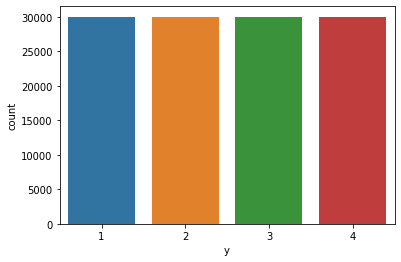

In [6]:
print(df['y'].value_counts())
sns.countplot(df['y'])

In [7]:
X = df['X']
y = df['y']
X_test = df2['X']
y_test = df2['y']

In [8]:
tokenized = [text_to_word_sequence(i) for i in X]
tokenized[0]

['wall',
 'st',
 'bears',
 'claw',
 'back',
 'into',
 'the',
 'black',
 'reuters',
 'reuters',
 'short',
 'sellers',
 'wall',
 "street's",
 'dwindling',
 'band',
 'of',
 'ultra',
 'cynics',
 'are',
 'seeing',
 'green',
 'again']

News Length 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d82e36dd0>]],
      dtype=object)

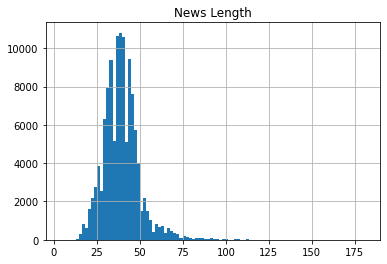

In [9]:
lens = pd.DataFrame([len(i) for i in tokenized], columns=['News Length'])
lens.hist(bins=100)

Maximum news length

In [10]:
max(len(i) for i in tokenized)

181

Average news length

In [11]:
sum(len(i) for i in tokenized)/len(tokenized)

39.44728333333333

In [12]:
token = Tokenizer()
token.fit_on_texts(X)

# Split dataset

In [13]:
from sklearn.model_selection import train_test_split

y = np.array(y).reshape(-1,1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(96000,)
(7600,)
(24000,)


# Encode text

In [14]:
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)
X_val = token.texts_to_sequences(X_val)

# Pad sequence

In [15]:
max_length = 181
X_train = pad_sequences(X_train,maxlen=max_length)
X_test = pad_sequences(X_test,maxlen=max_length)
X_val = pad_sequences(X_val,maxlen=max_length)

# One Hot Encoding on the label

In [16]:
encoder = OneHotEncoder()
encoder.fit(y)
y_train = encoder.transform(np.array(y_train).reshape(-1,1)).toarray()
y_test =  encoder.transform(np.array(y_test).reshape(-1,1)).toarray()
y_val =  encoder.transform(np.array(y_val).reshape(-1,1)).toarray()

# Read GLOVE Word Embedding

In [17]:
embedding_vector = {}
f = open('/content/drive/MyDrive/NewsCategorizationGlove/glove.6B.100d.txt')
for i in f:
    line = i.split(' ')
    word = line[0]
    coef = np.array(line[1:],dtype = 'float32')
    embedding_vector[word] = coef

# Create Embedding Matrix

In [18]:
vocab_size = len(token.word_index)+1

In [19]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size,embedding_dim))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 70337/70337 [00:00<00:00, 483032.11it/s]


# Create Model

In [20]:
X_train.shape

(96000, 181)

In [21]:
from keras.layers import GlobalMaxPooling1D, Reshape, Conv1D, MaxPooling1D

In [36]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix],input_length=max_length,trainable = False))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(Reshape((128,91)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(4,activation = 'softmax'))
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics = ['accuracy'])

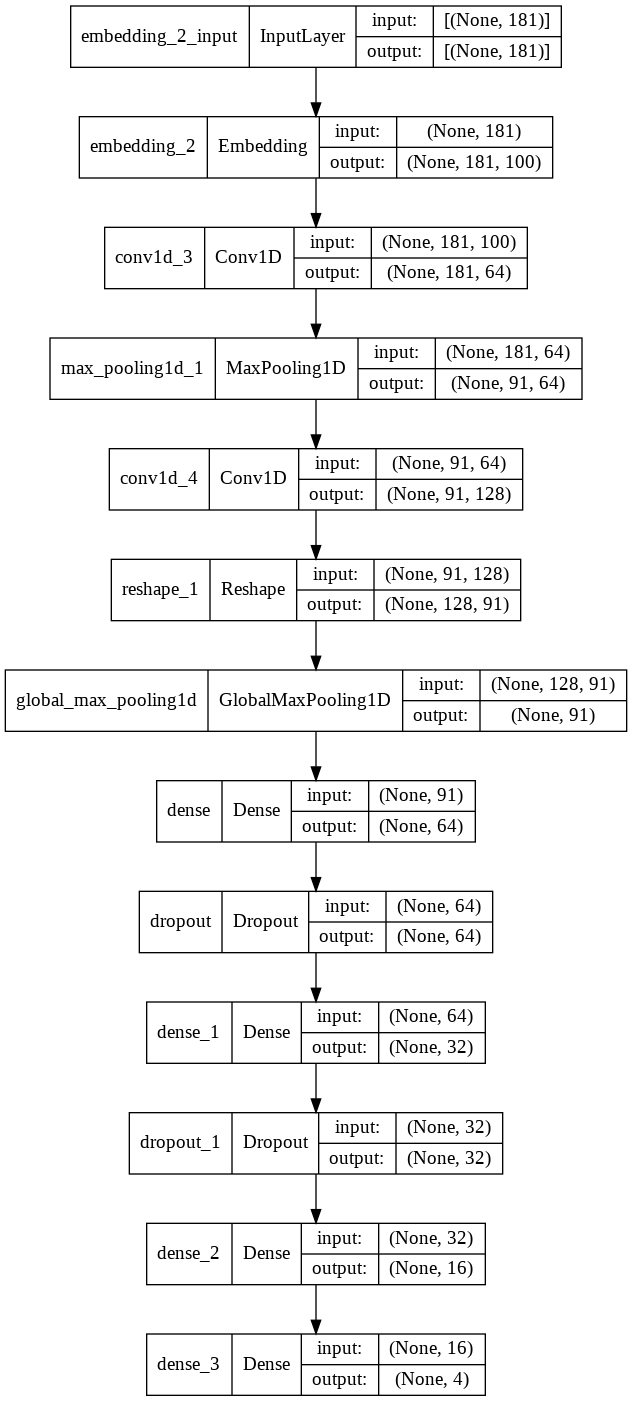

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 181, 100)          7033800   
                                                                 
 conv1d_7 (Conv1D)           (None, 181, 64)           19264     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 91, 64)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 91, 128)           24704     
                                                                 
 reshape_3 (Reshape)         (None, 128, 91)           0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 91)               0         
 balMaxPooling1D)                                     

In [38]:
history = model.fit(X_train,y_train,epochs = 10,batch_size=128,validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
750/750 [==============================] - 11s 13ms/step - loss: 0.7417 - accuracy: 0.6843 - val_loss: 0.3430 - val_accuracy: 0.8918
Epoch 2/10
750/750 [==============================] - 10s 13ms/step - loss: 0.3972 - accuracy: 0.8770 - val_loss: 0.3291 - val_accuracy: 0.9035
Epoch 3/10
750/750 [==============================] - 10s 13ms/step - loss: 0.3482 - accuracy: 0.8920 - val_loss: 0.3017 - val_accuracy: 0.9064
Epoch 4/10
750/750 [==============================] - 9s 12ms/step - loss: 0.3167 - accuracy: 0.9008 - val_loss: 0.3100 - val_accuracy: 0.9080
Epoch 5/10
750/750 [==============================] - 9s 12ms/step - loss: 0.2940 - accuracy: 0.9081 - val_loss: 0.2839 - val_accuracy: 0.9103
Epoch 6/10
750/750 [==============================] - 10s 13ms/step - loss: 0.2789 - accuracy: 0.9122 - val_loss: 0.2832 - val_accuracy: 0.9141
Epoch 7/10
750/750 [==============================] - 9s 12ms/step - loss: 0.2620 - accuracy: 0.9187 - val_loss: 0.2918 - val_accuracy: 0.

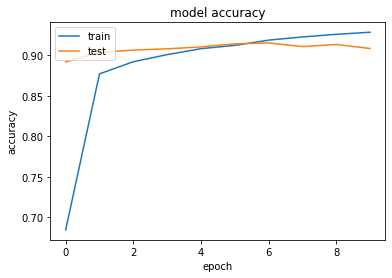

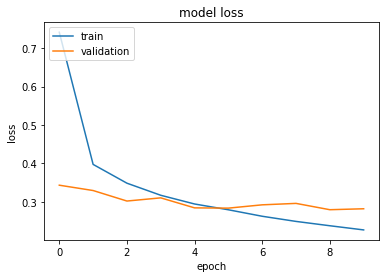

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [40]:
score = model.evaluate(X_test, y_test)
print("Test Accuracy:")
print(score[1])

238/238 [==============================] - 1s 5ms/step - loss: 0.2899 - accuracy: 0.9063
Test Accuracy:
0.906315803527832
